In [3]:
import sys
sys.path.insert(1, '../')

In [5]:
import eurec4a_environment
import eurec4a_environment.source_data
from eurec4a_environment.variables.boundary_layer.mixed_layer_height import calc_peak_RH

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
eurec4a_environment.__version__

'0+untagged.21.g1164f6f.dirty'

In [7]:
ds = eurec4a_environment.source_data.open_joanne_dataset()
ds

<xarray.Dataset>
Dimensions:          (height: 1001, sounding: 1068)
Coordinates:
  * height           (height) int64 0 10 20 30 40 ... 9960 9970 9980 9990 10000
  * sounding         (sounding) int64 807 808 809 810 811 ... 803 804 805 806
    launch_time      (sounding) datetime64[ns] 2020-01-17T14:32:32 ... 2020-0...
Data variables:
    lat              (sounding, height) float32 nan 13.620095 ... 15.734245
    lon              (sounding, height) float32 nan -56.97301 ... -57.028927
    p                (sounding, height) float32 nan 1016.41174 ... nan nan
    T                (sounding, height) float32 nan 26.134008 ... nan nan
    rh               (sounding, height) float32 nan 77.46414 ... nan nan
    wspd             (sounding, height) float32 nan nan ... 22.954624 23.012808
    wdir             (sounding, height) float32 nan nan ... 326.17032 326.2876
    u                (sounding, height) float32 nan nan ... 12.779419 12.772661
    v                (sounding, height) float32 nan nan ... -19.142838
    theta            (sounding, height) float32 297.84845 297.8957 ... 342.9537
    q                (sounding, height) float32 0.016377475 ... 1.7914394e-05
    PW               (sounding) float32 35.64949 35.750813 ... 27.053839
    low_height_flag  (sounding) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_flag       (sounding, height) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Platform         (sounding) object 'P3' 'P3' 'P3' ... 'HALO' 'HALO' 'HALO'
    flight_height    (sounding) float32 6785.827 6786.09 ... 11201.939 12807.684
    flight_lat       (sounding) float32 13.6276 13.8465 ... 13.449023 15.754024
    flight_lon       (sounding) float32 -56.9601 -55.9204 ... -57.063572
Attributes:
    Title:                        Gridded sounding dataset
    Campaign:                     EUREC4A-ATOMIC (Jan-Feb, 2020)
    Instrument:                   Vaisala RD-41
    Data-Processing for Level-2:  BatchAspen v3.4.3
    Author:                       Geet George
    Author-Email:                 geet.george@mpimet.mpg.de
    JOANNE-version:               0.5.7-alpha+0.g45fe69d.dirty
    Conventions:                  CF-1.7
    featureType:                  trajectory
    Creation-Time:                2020-06-18 22:28:31.582056 UTC

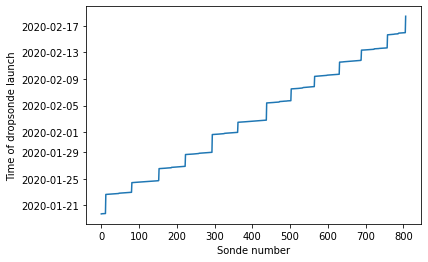

In [8]:
# pick out just the HALO sondes so that `launch_time` is strictly monotonic with time
ds = ds.where(ds.Platform == "HALO", drop=True)
ds.launch_time.plot()

In [9]:
calc_peak_RH(ds, altitude="height", rh="rh")

<xarray.DataArray 'height' (sounding: 807)>
array([770, 750, 660, ..., 780, 710, 620])
Coordinates:
    height       (sounding) int64 770 750 660 900 730 ... 900 780 780 710 620
  * sounding     (sounding) int64 0 1 2 3 4 5 6 ... 800 801 802 803 804 805 806
    launch_time  (sounding) datetime64[ns] 2020-01-19T16:55:28 ... 2020-02-18...
Attributes:
    standard_name:  geopotential_height
    long_name:      mixed layer height (from RH peak)
    description:    Height obtained by integrating upwards the atmospheric th...
    units:          m
    axis:           Z
    positive:       up

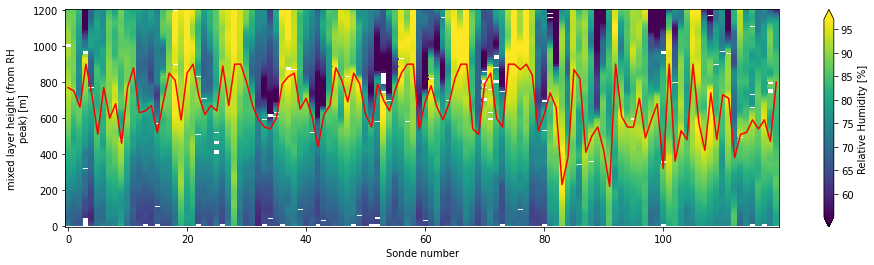

In [10]:
ds_ = ds.isel(sounding=slice(0, 120))
ds_.rh.sel(height=slice(0, 1200)).plot(y="height", robust=True, size=4, aspect=4.0)
calc_peak_RH(ds_, altitude="height", rh="rh").plot(color='red')

# Debugging/implementing the function

In [ ]:
import xarray as xr


def calc_peak_RH(ds, altitude="alt", rh="RH", z_min=200.0, z_max=900.0):
    """
    Calculate height at maximum relative humidity values
    """
    ds_mixed_layer = ds.sel({altitude: slice(z_min, z_max)})

    da_rh = ds_mixed_layer[rh]
    dims = list(ds.dims.keys())
    # drop the height coord
    del dims[dims.index(altitude)]

    peakRH_idx = da_rh.argmax(dim=altitude)
    da = da_rh.isel({altitude: peakRH_idx})[altitude]

    #da = xr.DataArray(h_peakRH, dims=dims, coords={d: ds[d] for d in dims})
    da.attrs["long_name"] = "mixed layer height (from RH peak)"
    da.attrs["units"] = "m"

    return da

In [ ]:
ds0 = ds_.isel(num=slice(0, 1)).sel({altitude: slice(200, 900)})
ds0.rh.plot(y="height", hue="num")

altitude = "height"
peakRH_idx = ds0['rh'].argmax(dim=altitude)
da = ds0['rh'].isel({altitude: peakRH_idx})[altitude]
for v in da.values:
    print(v)
    plt.gca().axhline(v)